In [1]:
overwrite = False # this should be False once the result is obtained

import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
# sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
class args:
    out_dir = "/storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output"
# import argparse
# p = argparse.ArgumentParser(description="Unbindling script",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--out_dir", default="/storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output", type=str, help="output root directory")
# args = p.parse_args()

In [3]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")

# load per GRB best: tw, TS, ns, pre_p

In [5]:
tws, tss, nss, pre_ps = [], [], [], []
tw_in_seconds = [10, 25, 50, 100, 250, 500]
for idx in df.grb_name.index:
    grb_name = df.grb_name[idx]
    ts_ns_p = np.load(ANA_DIR+f"/unblind/ts_ns_p/{grb_name}_ts_ns_p.npy")
    ts_grb = ts_ns_p['ts']
    ns_grb = ts_ns_p['ns']
    pre_p_grb = ts_ns_p['pval']
    min_i = np.argmin(pre_p_grb)
    tws.append(tw_in_seconds[min_i])
    tss.append(ts_grb[min_i])
    nss.append(ns_grb[min_i])
    pre_ps.append(pre_p_grb[min_i])
    

In [6]:
df_result = df.copy()
df_result['tw'] = np.array(tws)
df_result['ts'] = np.array(tss)
df_result['ns'] = np.array(nss)
df_result['pre_p'] = np.array(pre_ps)

In [7]:
df_result.head()

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,decl_source,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p
0,GRB200529B,GRB200529504,337.200000,55.230000,3.506136,58998.503432,0.000539,0.000539,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,0.000005,NaN,58998.503701,True,10,0.0000,0.000000,1.000000
1,GRB200529A,GRB200529039,238.763917,-11.073639,0.000233,58998.039294,0.001004,0.000984,0,Swift,Swift,Swift,0.000005,NaN,58998.039796,True,500,0.0018,0.049397,0.190253
2,GRB200528A,GRB200528436,176.637458,58.192583,0.000194,58997.435683,0.000700,0.000655,0,Swift,Swift,Swift,0.000029,NaN,58997.436033,True,10,0.0000,0.000000,1.000000
3,GRB200525A,GRB200525611,20.610000,-8.520000,4.536708,58994.611328,0.001081,0.001081,1,Fermi_GBM,Fermi_GBM,Fermi_GBM,0.000009,NaN,58994.611869,True,10,0.0000,0.000000,1.000000
4,GRB200524A,GRB200524211,212.750000,60.966667,0.100000,58993.211115,0.000445,0.000437,0,IPN,IPN,IPN,0.000014,1.256,58993.211338,True,10,0.0000,0.000000,1.000000


# for each GRB, trial correct due to stacked time windows

In [9]:
def get_post_p_for_grb(grb_name, pre_p):
    """
    effective trial correction due to multiple time windows
    
    Parameters
    ----------
        grb_name: str
            name of the grb
        pre_p: float or array_like
            one or multiple pre_trial p value(s)
        
    Returns
    -------
        post_p: float or array_like
            one or multiple post_trial p value(s)
    """
    pre_p = np.float32(pre_p)
    pre_post = np.load(ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
    idx = np.searchsorted(pre_post['pre_trial_p'], pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, pre_post['post_trial_p'].shape[0] - 1)
    return pre_post['post_trial_p'][idx]

In [10]:
###### ~ 2 cpu min
df_result['post_p'] = df_result.apply(
    lambda row : get_post_p_for_grb(row['grb_name'],row['pre_p']), 
    axis = 1
)

## save result01

In [6]:
if overwrite:
    df_result.to_pickle(args.out_dir+f"/unblind/result01.pkl")
else: 
    df_result = pd.read_pickle(args.out_dir+f"/unblind/result01.pkl")

In [7]:
df_result.sort_values("post_p").head()

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,...,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p,post_p
1632,GRB140807A,GRB140807500,200.160000,26.490000,4.394479,56876.499692,0.000006,0.000006,1,Fermi_GBM,...,Fermi_GBM,1.286500e-06,NaN,56876.499695,True,100,19.469318,1.083586,0.000009,0.000046
1075,GRB160804D,GRB160804968,93.260000,-7.660000,9.065763,57604.967751,0.000002,0.000002,1,Fermi_GBM,...,Fermi_GBM,2.808000e-07,NaN,57604.967752,True,100,14.113972,2.808878,0.000197,0.000961
1079,GRB160802A,GRB160802259,28.029167,71.366667,0.441667,57602.259371,0.000209,0.000190,0,IPN,...,IPN,6.839900e-05,NaN,57602.259475,True,50,11.205534,2.735372,0.000260,0.001283
316,GRB190321A,GRB190321363,315.700000,6.620000,3.572227,58563.362889,0.000646,0.000646,1,Fermi_GBM,...,Fermi_GBM,6.589900e-06,NaN,58563.363212,True,100,13.238818,1.795262,0.000283,0.001333
748,GRB170915A,GRB170915161,120.260000,-38.420000,2.710746,58011.160766,0.000181,0.000181,1,Fermi_GBM,...,Fermi_GBM,7.408500e-06,NaN,58011.160856,True,100,9.440196,1.778291,0.000360,0.001823


In [144]:
from scipy import stats
stats.norm.sf(3)

0.0013498980316300933

In [161]:
df_result.sort_values("post_p").reset_index().iloc[21]

index                         1916
grb_name                GRB130723A
grb_name_GBM          GRB130723092
ra                          217.77
dec                         -16.86
source_uncertainty        6.080208
mjd_start             56496.092053
t100                      0.000095
t90                       0.000095
gbm                              1
ra_source                Fermi_GBM
decl_source              Fermi_GBM
pos_error_source         Fermi_GBM
fluence                   0.000001
redshift                       NaN
t_center                56496.0921
hasHealpix                    True
tw                              10
ts                        6.948595
ns                         0.98847
pre_p                     0.001932
post_p                    0.009131
Name: 21, dtype: object

## trial correct the p-value due to 2268 GRBs
gather all the most single-siginificant window-corrected p-values from background runs

In [12]:
###### ~ 1 cpu min
files = glob(ANA_DIR+f"/binomial_test/null_binom/multiple_run_post_p/multiple_run_post_p_numRun*_batchIdx*.npy")
files = sorted(files, key=lambda x: int(x[x.find("_batchIdx")+9:x.find(".npy")]))
background_single_most_significant_ps = np.hstack([np.load(i).min(axis=1) for i in files])

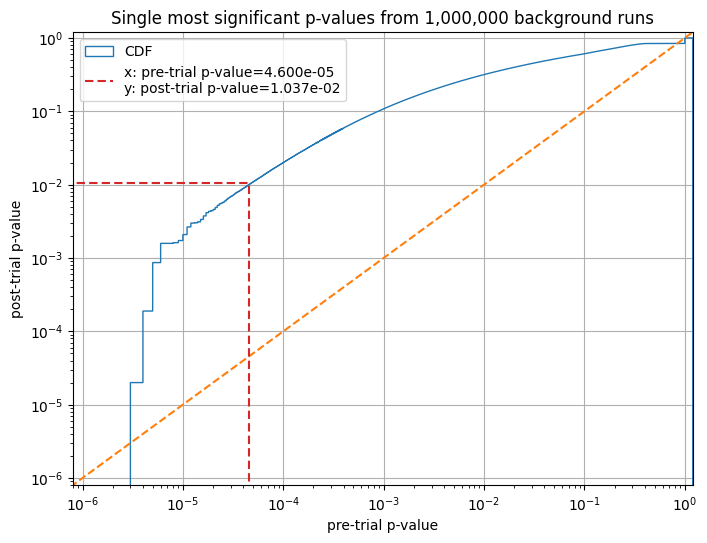

In [13]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
n,bins,patches=ax.hist(background_single_most_significant_ps, 
        bins=np.r_[np.unique(background_single_most_significant_ps),1.2], 
        density=True, 
        cumulative=True, 
        label=f'CDF',
        histtype='step')
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--")

p_x = df_result.post_p.min()
p_y = n[np.searchsorted(bins, p_x, side='right')]
ax.plot([p_x, p_x, 0],[0, p_y, p_y], 
        color=sns.color_palette()[3], dashes=[4, 2], 
        label=f"x: pre-trial p-value={p_x:.3e} \ny: post-trial p-value={p_y:.3e}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.8e-6, 1.2)
ax.set_ylim(0.8e-6, 1.2)
ax.set_xlabel("pre-trial p-value")
ax.set_ylabel("post-trial p-value")
ax.set_title(f"Single most significant p-values from 1,000,000 background runs")
ax.grid()
ax.legend()

In [14]:
from scipy import stats
print(f"The post-trial single most significant p-value is {p_y} and it's a {stats.norm.isf(p_y)}-\sigma result")

The post-trial single most significant p-value is 0.010371 and it's a 2.312648003164816-\sigma result


# binomial test

In [15]:
def binomial_test(p_values, epsilon=None):
    """
    Perform IceCube binomial test
    
    Parameters
    ----------
        p_values: array_like
            an array of p-values
        
    Returns
    -------
        best_k: int
            number of p-values that minimizes the binomial probability
            Note this is 1-index'ed
        
        best_binomial_p: float
            the optimized binomial probability
            
        threshold_p_value: float
            the best_k-th p_value (a.k.a. p_k)
            this GRB and all GRBs having p_values smaller than this threshold_p_value are important
            
        indices: array_like
            GRB indices after sorting (assume the input p_values' indices are from 0 - 2267)
            
        
        binomial_ps: array_like
            binomial probabilities for different k=1,2,...,N
    """
    p_values = np.array(p_values)
    N = p_values.size
    ks = np.argsort(p_values)
    p_values = np.sort(p_values)
    binomial_ps = stats.binom.sf(np.r_[0:N], N, p_values)
    best_k = np.argmin(binomial_ps) + 1
    best_binomial_p = binomial_ps[best_k - 1]
    if (epsilon is not None) and (1.0 - best_binomial_p < epsilon):
        return N, 1, p_values[-1], ks, binomial_ps
    threshold_p_value = p_values[best_k - 1]
    return best_k, best_binomial_p, threshold_p_value, ks, binomial_ps

In [16]:
binomial_result = binomial_test(df_result['post_p'])

In [135]:
def plot_binom_example_from_p_values(p_values, mark_indices=[], mark_label="Marked p-value(s)", save_fig=False):
    """
    p_values here are assumed corrected already
    
    Parameters
    ----------
        p_values: array_like
            shape: 2268
            
        mark_indices: array_like
            0-indexed: 0,1,2,...,2267
            if provided, draw those p-values differently
            
        save_fig: bool
            do we plot/save (True/False) the plot
        
    Returns
    -------
        ax: matplotlib axes
            
        binomial_result: dict
    
    """
    ## example null hypothesis Binomial Test
    binomial_result = binomial_test(p_values)

    fig, ax = plt.subplots(figsize=(10,8), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    sorted_p_values = np.sort(p_values)
    ax.scatter(x, sorted_p_values, marker='.',label="Pre-trial p-values", s=30)
    if len(mark_indices) > 0:
        mark_indices = np.array(mark_indices)
        sorted_indices = np.argsort(p_values)
        mark_ks = np.ravel([np.argwhere(sorted_indices==x) for x in mark_indices]) + 1
        ax.scatter(mark_ks, sorted_p_values[mark_ks-1], color=sns.color_palette()[2], s=120, marker="x", label=mark_label)
    
    
    # Binomial Probability
    ax.scatter(x, binomial_result[4], marker='v',label="Binomial p-values", s=30)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle=(0, (1, 1)), alpha=0.5, color=sns.color_palette()[5], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle=(0, (1, 1)), alpha=0.5, color=sns.color_palette()[5], linewidth=2,
               label=f"k = {binomial_result[0]}\n" + r"$P_{binomial}$" + f" = {binomial_result[1]:.4f}")
    
    # uniform line
    ax.plot(x, x/2268., "--", color=sns.color_palette()[7])

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend(fontsize=16, frameon=False)
    if save_fig:
        fig.savefig(ANA_DIR+f"/unblind/binomial_plot.png")
    return ax, binomial_result

In [136]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [137]:
tmp_style = {
    'text.usetex' : False,
    'mathtext.rm' : 'Times New Roman',
    'mathtext.it' : 'Times New Roman:italic',
    'mathtext.bf' : 'Times New Roman:bold',
    'mathtext.fontset': 'stix',
    'xtick.labelsize' : 16,
    'ytick.labelsize' : 16,
    'xtick.major.size' : 5,
    'ytick.major.size' : 5,
    'xtick.minor.size' : 3,
    'ytick.minor.size' : 3,
    'axes.labelsize' : 18,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'ytick.right' : True,
    'xtick.top' : True,
    'axes.grid' : True,
    'axes.grid.which' : 'major',
    'axes.linewidth': 1.5,
    'grid.color' : 'lightgrey',
    'grid.alpha' : 0.4,
    'grid.linewidth' : 0.75,
    'lines.linewidth' : 1.5,
    'font.size' : 16,
    'image.cmap': 'PuBu',
}

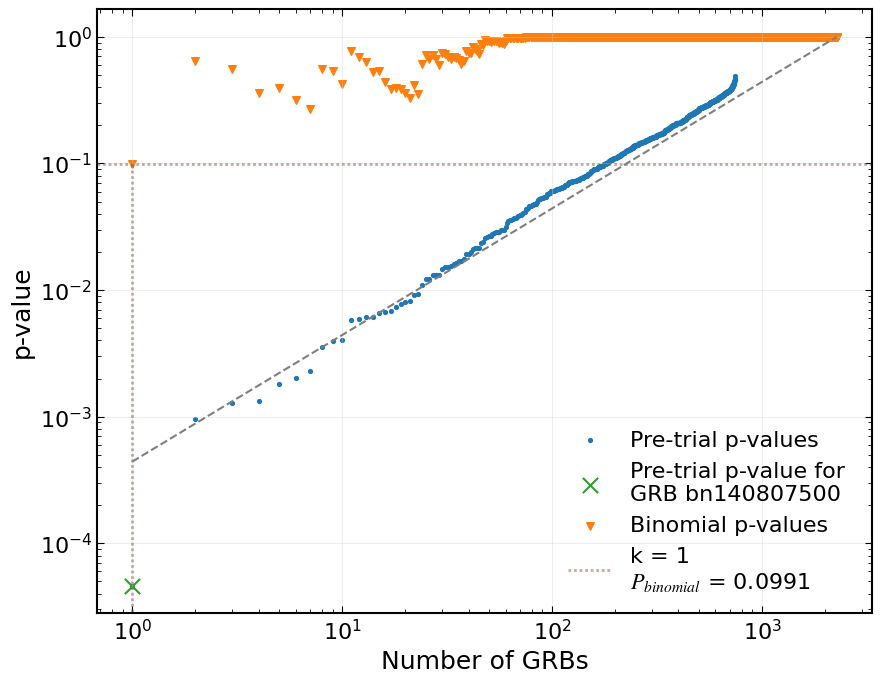

In [138]:
with mpl.rc_context(tmp_style):
    plot_binom_example_from_p_values(
        np.array(df_result['post_p']), 
        mark_indices=binomial_result[3][:binomial_result[0]],
        mark_label="Pre-trial p-value for \nGRB bn140807500",
        save_fig=True
    )


In [22]:
df_result.sort_values('post_p').head(5)

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,...,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p,post_p
1632,GRB140807A,GRB140807500,200.160000,26.490000,4.394479,56876.499692,0.000006,0.000006,1,Fermi_GBM,...,Fermi_GBM,1.286500e-06,NaN,56876.499695,True,100,19.469318,1.083586,0.000009,0.000046
1075,GRB160804D,GRB160804968,93.260000,-7.660000,9.065763,57604.967751,0.000002,0.000002,1,Fermi_GBM,...,Fermi_GBM,2.808000e-07,NaN,57604.967752,True,100,14.113972,2.808878,0.000197,0.000961
1079,GRB160802A,GRB160802259,28.029167,71.366667,0.441667,57602.259371,0.000209,0.000190,0,IPN,...,IPN,6.839900e-05,NaN,57602.259475,True,50,11.205534,2.735372,0.000260,0.001283
316,GRB190321A,GRB190321363,315.700000,6.620000,3.572227,58563.362889,0.000646,0.000646,1,Fermi_GBM,...,Fermi_GBM,6.589900e-06,NaN,58563.363212,True,100,13.238818,1.795262,0.000283,0.001333
748,GRB170915A,GRB170915161,120.260000,-38.420000,2.710746,58011.160766,0.000181,0.000181,1,Fermi_GBM,...,Fermi_GBM,7.408500e-06,NaN,58011.160856,True,100,9.440196,1.778291,0.000360,0.001823


In [37]:
def get_binomial_post_p(binomial_pre_p):
    files = glob(ANA_DIR+f"/binomial_test/null_binom/binomial_results/null_binomial_results_numRun1000000_seed*.npy")
    files = sorted(files, key=lambda x: int(x[x.find("_seed")+5:x.find(".npy")]))
    best_binomial_p_100000000 = np.concatenate([np.load(file) for file in files])[:,1]
    ######## pre-post mapping #######
    hist, bin_edges = np.histogram(best_binomial_p_100000000, 
                               bins=np.r_[
                                   np.logspace(np.log10(best_binomial_p_100000000.min()),np.log10(1.0), 100000), 
                                   1.2
                               ], 
                               density=True)
    pre_trial_p = bin_edges
    post_trial_p = np.r_[np.cumsum(hist*np.diff(bin_edges)), 1]
    dt = np.dtype([('pre_trial_p', np.float32), ('post_trial_p', np.float32)])
    pre_post = np.transpose(np.array([pre_trial_p, post_trial_p]))
    pre_post = np.array(list(map(tuple, pre_post)), dtype=dt)
    #################################
    idx = np.searchsorted(pre_post['pre_trial_p'], binomial_pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, len(pre_post['post_trial_p']) - 1)
    return pre_post['post_trial_p'][idx]

In [38]:
print(f"The final binomial post-trial p value is: {get_binomial_post_p(binomial_result[1])}")

The final binomial post-trial p value is: 0.6478163003921509


0.09907241997296044 0.6478754564787542


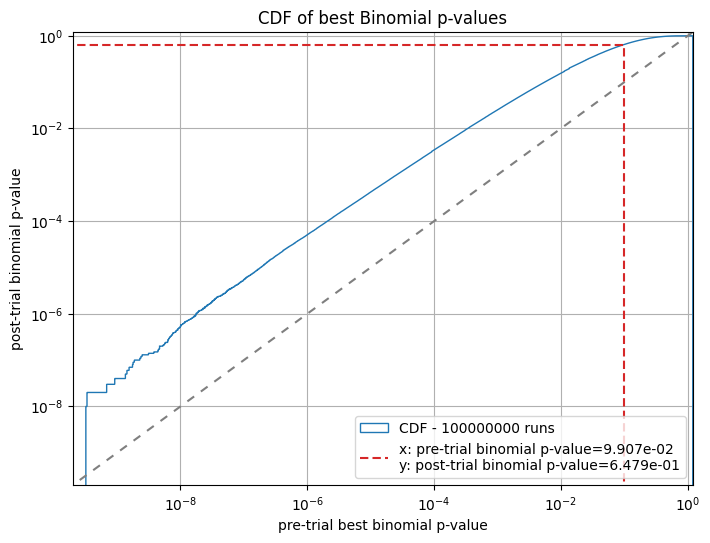

In [41]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
files = glob(ANA_DIR+f"/binomial_test/null_binom/binomial_results/null_binomial_results_numRun1000000_seed*.npy")
files = sorted(files, key=lambda x: int(x[x.find("_seed")+5:x.find(".npy")]))
best_binomial_p_100000000 = np.concatenate([np.load(file) for file in files])[:,1]
n,bins,patches=ax.hist(best_binomial_p_100000000, 
                       bins=np.r_[
                           np.logspace(np.log10(best_binomial_p_100000000.min()),np.log10(1.0), 100000), 
                           1.2
                       ],
        density=True, 
        cumulative=True, 
        label=f'CDF - {best_binomial_p_100000000.size} runs',
        histtype='step')

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, "--", color=sns.color_palette()[7], dashes=[4,4])
# RESULT
bp_x = binomial_result[1]
bp_y = n[np.searchsorted(bins, bp_x, side='right')]
ax.plot([bp_x, bp_x, 0],[0, bp_y, bp_y], 
        color=sns.color_palette()[3], dashes=[4, 2], 
        label=f"x: pre-trial binomial p-value={bp_x:.3e} \ny: post-trial binomial p-value={bp_y:.3e}")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.2e-9, 1.2)
ax.set_ylim(0.2e-9, 1.2)
ax.set_xlabel("pre-trial best binomial p-value")
ax.set_ylabel("post-trial binomial p-value")
ax.set_title(f"CDF of best Binomial p-values")
ax.grid(True)
ax.legend(loc='lower right')
print(bp_x, bp_y)


In [27]:
df_result.sort_values('post_p').head()

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,...,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p,post_p
1632,GRB140807A,GRB140807500,200.160000,26.490000,4.394479,56876.499692,0.000006,0.000006,1,Fermi_GBM,...,Fermi_GBM,1.286500e-06,NaN,56876.499695,True,100,19.469318,1.083586,0.000009,0.000046
1075,GRB160804D,GRB160804968,93.260000,-7.660000,9.065763,57604.967751,0.000002,0.000002,1,Fermi_GBM,...,Fermi_GBM,2.808000e-07,NaN,57604.967752,True,100,14.113972,2.808878,0.000197,0.000961
1079,GRB160802A,GRB160802259,28.029167,71.366667,0.441667,57602.259371,0.000209,0.000190,0,IPN,...,IPN,6.839900e-05,NaN,57602.259475,True,50,11.205534,2.735372,0.000260,0.001283
316,GRB190321A,GRB190321363,315.700000,6.620000,3.572227,58563.362889,0.000646,0.000646,1,Fermi_GBM,...,Fermi_GBM,6.589900e-06,NaN,58563.363212,True,100,13.238818,1.795262,0.000283,0.001333
748,GRB170915A,GRB170915161,120.260000,-38.420000,2.710746,58011.160766,0.000181,0.000181,1,Fermi_GBM,...,Fermi_GBM,7.408500e-06,NaN,58011.160856,True,100,9.440196,1.778291,0.000360,0.001823
1374,GRB150630A,GRB150630223,116.810000,-21.310000,2.177747,57203.222761,0.000270,0.000264,1,Fermi_GBM,...,Fermi_GBM,1.077500e-05,NaN,57203.222896,True,10,9.545152,1.868425,0.000402,0.002032
1392,GRB150604A,GRB150604284,306.270000,-46.720000,5.410663,57177.283651,0.000610,0.000610,1,Fermi_GBM,...,Fermi_GBM,1.464500e-06,NaN,57177.283956,True,50,10.421208,1.809883,0.000451,0.002293
117,GRB191221A,GRB191221802,40.830000,-43.040000,4.986095,58838.801713,0.000035,0.000026,1,Fermi_GBM,...,Fermi_GBM,4.627600e-07,NaN,58838.801730,True,500,11.107037,5.714433,0.000712,0.003549
1310,GRB150902A,GRB150902733,214.979600,-69.353600,0.001190,57267.733083,0.000213,0.000157,0,Fermi_LAT,...,Fermi_LAT,8.319200e-05,NaN,57267.733189,True,500,7.625672,2.570575,0.000811,0.003953
167,GRB191001A,GRB191001279,267.104167,11.650000,5.000000,58757.279015,0.000278,0.000278,0,IPN,...,IPN,4.579500e-06,NaN,58757.279154,True,25,8.965207,1.906207,0.000841,0.004001


In [28]:
df_result[df_result['grb_name'].isin(["GRB190114C", "GRB190829A"])]

,grb_name,grb_name_GBM,ra,dec,source_uncertainty,mjd_start,t100,t90,gbm,ra_source,...,pos_error_source,fluence,redshift,t_center,hasHealpix,tw,ts,ns,pre_p,post_p
186,GRB190829A,GRB190829830,44.544042,-8.958361,0.000233,58724.830475,0.001271,0.000687,0,Swift,...,Swift,0.000015,0.0785,58724.83111,True,100,1.236526,0.743892,0.062953,0.202327
358,GRB190114C,GRB190114873,54.504833,-26.946361,0.000054,58497.872944,0.004192,0.001347,0,Swift,...,Swift,0.000443,0.4200,58497.87504,True,10,0.000000,0.000000,1.000000,1.000000


In [29]:
df_result.sort_values('post_p').head(20).grb_name.to_list()

['GRB140807A',
 'GRB160804D',
 'GRB160802A',
 'GRB190321A',
 'GRB170915A',
 'GRB150630A',
 'GRB150604A',
 'GRB191221A',
 'GRB150902A',
 'GRB191001A',
 'GRB161119A',
 'GRB181203B',
 'GRB191022A',
 'GRB170915B',
 'GRB130216B',
 'GRB130608A',
 'GRB200128A',
 'GRB121123B',
 'GRB170726A',
 'GRB181007A']